# **GENERATION DE PARTITION DE MUSIQUE : RESEAU LSTM**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os
import json

In [3]:
sys.path.append('/content/drive/MyDrive/LSTM')
sys.path.append('/content/drive/MyDrive/data')
sys.path.append('/content/drive/MyDrive/')

In [4]:
from melodypreprocessor import *
from melodygenerator import *
from LSTM import *
from train import *
from extract_data import *
from visualization import n_measure

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

import matplotlib.pyplot as plt

In [5]:
melody_preprocessor = MelodyPreprocessor("/content/drive/MyDrive/data/dataset3A.json", batch_size=32)
train_dataset = melody_preprocessor.create_training_dataset()
vocab_size = melody_preprocessor.number_of_tokens_with_padding
max_length_melody = melody_preprocessor.max_melody_length

print("Taille du vocabulaire :",vocab_size)
print("Taille de la plus grande mélodie :",max_length_melody)

Taille du vocabulaire : 240
Taille de la plus grande mélodie : 40


## **Modèle LSTM**

In [6]:
embedding_dim = 64
model = LSTMModel(vocab_size,embedding_dim,max_length_melody)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
epochs = 10
iters,losses = train(train_dataset,model,epochs)

Training the model ...


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 8 Batch 509 Loss 0.7998656034469604
Epoch 8 Batch 510 Loss 0.6913970112800598
Epoch 8 Batch 511 Loss 0.6300755143165588
Epoch 8 Batch 512 Loss 0.7274118065834045
Epoch 8 Batch 513 Loss 0.6988504528999329
Epoch 8 Batch 514 Loss 0.7996350526809692
Epoch 8 Batch 515 Loss 0.847427248954773
Epoch 8 Batch 516 Loss 0.8587967753410339
Epoch 8 Batch 517 Loss 0.9373741149902344
Epoch 8 Batch 518 Loss 0.9857156872749329
Epoch 8 Batch 519 Loss 0.9973255395889282
Epoch 8 Batch 520 Loss 1.0207083225250244
Epoch 8 Batch 521 Loss 0.8595693111419678
Epoch 8 Batch 522 Loss 0.8201810121536255
Epoch 8 Batch 523 Loss 0.9692335724830627
Epoch 8 Batch 524 Loss 0.7521561980247498
Epoch 8 Batch 525 Loss 0.9799875020980835
Epoch 8 Batch 526 Loss 1.1604032516479492
Epoch 8 Batch 527 Loss 0.7590456604957581
Epoch 8 Batch 528 Loss 1.0100126266479492
Epoch 8 Batch 529 Loss 0.9927753806114197
Epoch 8 Batch 530 Loss 0.9452722668647766

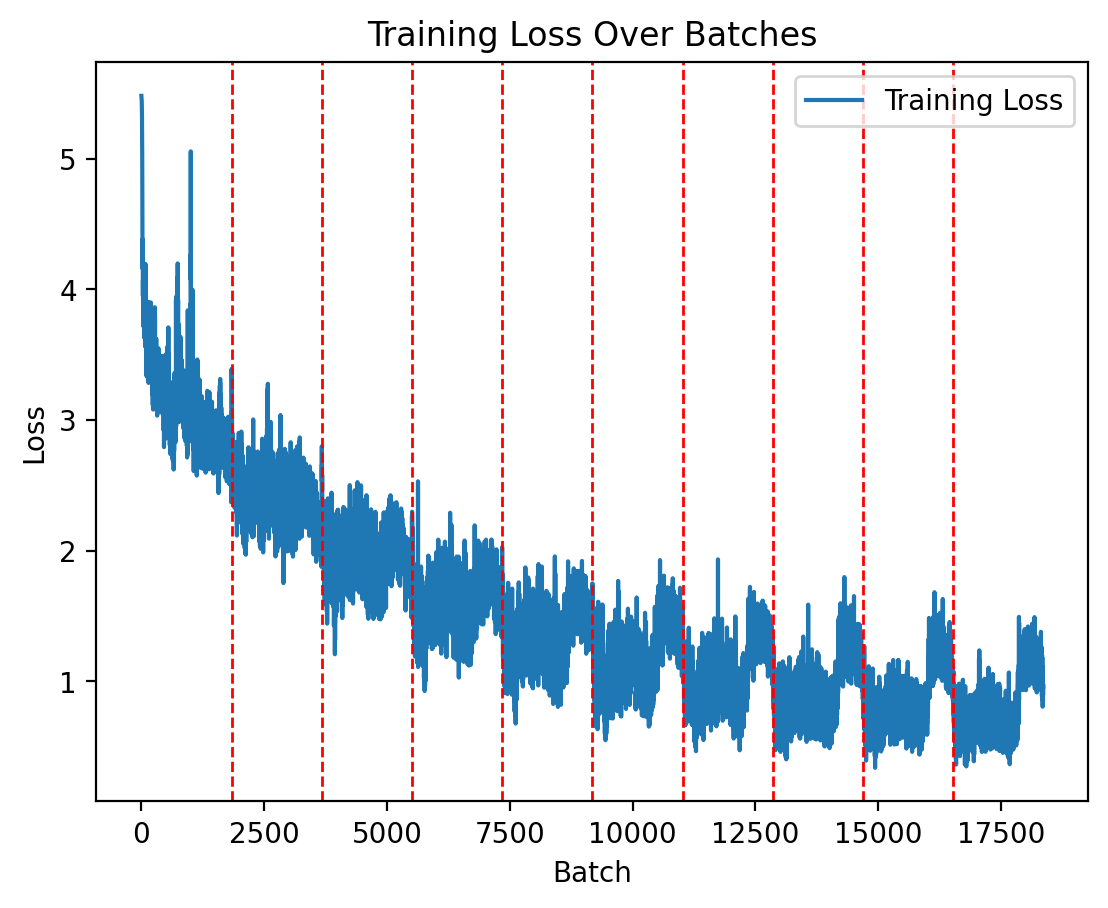

In [8]:
def plot_losses(iters,losses,batchs):
    plt.plot(iters,losses, label='Training Loss')
    for i in range(batchs,len(iters),batchs):
        plt.axvline(x=i, color='r', linestyle='--', linewidth=1)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Batches')
    plt.legend()
    plt.show()

plot_losses(iters,losses,1836)

## **Génération de mesures**

In [9]:
melody_generator = MelodyGenerator(model,melody_preprocessor.tokenizer,30)

In [10]:
def generate_seq(original,lg_debut,lg_predict):
    original_size= len(original)
    print(f'Nombre de mesures dans l\'original : {original_size}')
    size=lg_debut+lg_predict
    debuts=[]
    fins=[]
    for i in range(size,original_size+1):
        seq_debut= [ n for  m in original[i-size:i-lg_predict] for n in m]
        seq_originale= [ n for  m in original[i-size:i] for n in m if i<original_size]
        debuts.append(seq_debut)
        fins.append(seq_originale)
    return debuts,fins,original_size

def generate_decalage(original,lg_debut,lg_predict,mode=2,k=40,first_proba=0.8,time_signature="2/4",forcing=0.2):
    '''Genere une partie A
      Parametres:
            original (liste de string) : Partie originale
            lg_debut (int) : Longueur sequence de départ en mesure
            lg_fin (int) : Longueur sequence prédite en mesure
            ***param du melody_generator.generate()
    '''
    melodie=[]
    debuts,fins,original_size=generate_seq(original,lg_debut,lg_predict)
    melodie.append(debuts[0])
    probas= [[ 1 for m in debuts[0] for _ in m ]]
    size=lg_debut+lg_predict
    for i in range(len(debuts)):
      new_melodie,p=melody_generator.generate(debuts[i],mode=mode,k=k,forcing=forcing)
      new_melodie=new_melodie.split(' ')[len(debuts[i]):]
      new_melodie=n_measure(new_melodie,lg_predict,time_signature)
      melodie.append(new_melodie)
      p= p[len(debuts[i]):len(debuts[i])+len(new_melodie)]
      #print(new_melodie)
      probas.append(p)
      print(f'Mesure {size+i} : generated')
    melodie = [ n for measure in melodie for n in measure ]
    print("Melodie generated")
    return melodie,probas

In [25]:
error_part_A= ['Sarau para Radamés','DESPREZADO','ACARICIANDO']

#### Coefficient forcing = 0

In [26]:
melodies_generated=[]

In [28]:
for _ in range(10):
  print("Generating a melody...")
  seq=extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
  print(seq[0])
  original= extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]
  while seq[1]!= "2/4" or seq[0] in error_part_A:
      seq=extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
      original= extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]
  new_melody,p = generate_decalage(original,2,1,mode=2,k=10,first_proba=0.6,forcing=0)
  original=[ n for m in original for n in m]
  melodies_generated.append((seq,new_melody,original,p))

  print(new_melody)
  print(original)
  print(p)
  print('--')

Generating a melody...
Pedacinhos do Céu
Nombre de mesures dans l'original : 32
Mesure 3 : generated
Mesure 4 : generated
Mesure 5 : generated
Mesure 6 : generated
Mesure 7 : generated
Mesure 8 : generated
Mesure 9 : generated
Mesure 10 : generated
Mesure 11 : generated
Mesure 12 : generated
Mesure 13 : generated
Mesure 14 : generated
Mesure 15 : generated
Mesure 16 : generated
Mesure 17 : generated
Mesure 18 : generated
Mesure 19 : generated
Mesure 20 : generated
Mesure 21 : generated
Mesure 22 : generated
Mesure 23 : generated
Mesure 24 : generated
Mesure 25 : generated
Mesure 26 : generated
Mesure 27 : generated
Mesure 28 : generated
Mesure 29 : generated
Mesure 30 : generated
Mesure 31 : generated
Mesure 32 : generated
Melodie generated
['B5-2.0', 'B5-0.25', 'A5-0.25', 'G5-0.25', 'D5-0.25', 'D5-0.25', 'B4-0.25', 'G4-0.25', 'D5-0.25', 'C#5-1.0', 'E5-0.25', 'B4-0.75', 'B4-0.25', 'G#4-0.25', 'G#4-0.25', 'E5-0.25', 'D5-0.25', 'D5-0.25', 'B4-0.5', 'A5-0.5', 'F#5-0.25', 'G5-0.25', 'B5-0.

In [29]:
generated = [ {'Title' : s[0] , "Time_signature" : s[1], 'Part': s[2], 'Key' : s[3] ,'Generated' : m , 'Original' : o , 'Proba' : [ str(prob) for proba in p for prob in proba] } for (s,m,o,p) in melodies_generated ]
print(len(generated))

19


In [30]:
with open("/content/drive/MyDrive/Generated/lstm_0.json","w") as f:
    json.dump(generated,f,indent=2)

#### Coefficient forcing = 0.2

In [31]:
melodies_generated=[]

In [32]:
for _ in range(10):
  print("Generating a melody...")
  seq=extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
  print(seq[0])
  original= extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]
  while seq[1]!= "2/4" or seq[0] in error_part_A:
      seq=extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
      original= extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]
  new_melody,p = generate_decalage(original,2,1,mode=2,k=10,first_proba=0.6,forcing=0.2)
  original=[ n for m in original for n in m]
  melodies_generated.append((seq,new_melody,original,p))

  print(new_melody)
  print(original)
  print(p)
  print('--')

Generating a melody...
HILDA (Teu Beijo)
Nombre de mesures dans l'original : 16
Mesure 3 : generated
Mesure 4 : generated
Mesure 5 : generated
Mesure 6 : generated
Mesure 7 : generated
Mesure 8 : generated
Mesure 9 : generated
Mesure 10 : generated
Mesure 11 : generated
Mesure 12 : generated
Mesure 13 : generated
Mesure 14 : generated
Mesure 15 : generated
Mesure 16 : generated
Melodie generated
['E5-0.5', 'D5-0.25', 'rest-0.25', 'B4-0.5', 'G4-0.25', 'G4-0.25', 'F#4-0.5', 'F4-0.25', 'F#4-0.25', 'D5-0.5', 'C#5-0.25', 'A4-0.25', 'D5-0.25', 'D5-1.0', 'rest-0.5', 'rest-0.25', 'E5-0.5', 'F#4-0.25', 'G#4-0.25', 'C5-0.5', 'C#5-0.25', 'A4-0.5', 'B4-0.25', 'C#5-0.25', 'C#5-0.5', 'B4-0.25', 'A#4-0.25', 'G4-1.0', 'rest-1.0', 'D6-0.25', 'D6-0.25', 'C#6-0.25', 'C6-0.25', 'A-5-0.25', 'B5-0.25', 'D5-0.25', 'D6-0.25', 'F5-0.25', 'C5-0.25', 'D5-0.25', 'G5-0.5', 'D5-0.25', 'G5-0.5', 'C4-0.5', 'B3-0.25', 'G4-0.25', 'A4-0.25', 'F4-0.25', 'C5-0.5', 'G#4-0.25', 'A5-0.25', 'A-5-0.25', 'G5-0.5', 'rest-0.25', 

In [33]:
1generated = [ {'Title' : s[0] , "Time_signarue" : s[1], 'Part': s[2], 'Key' : s[3] ,'Generated' : m , 'Original' : o , 'Proba' : [ str(prob) for proba in p for prob in proba] } for (s,m,o,p) in melodies_generated ]
print(len(generated))

10


In [34]:
with open("/content/drive/MyDrive/Generated/lstm_02.json","w") as f:
    json.dump(generated,f,indent=2)

#### Génération avec un coefficient forcing = 0.8

In [45]:
melodies_generated=[]

In [46]:
for _ in range(10):
  print("Generating a melody...")
  seq=extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
  print(seq[0])
  original= extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]
  while seq[1]!= "2/4" or seq[0] in error_part_A:
      seq=extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
      original= extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]
  new_melody,p = generate_decalage(original,2,1,mode=2,k=10,first_proba=0.6,forcing=0.8)
  original=[ n for m in original for n in m]
  melodies_generated.append((seq,new_melody,original,p))

  print(new_melody)
  print(original)
  print(p)
  print('--')

Generating a melody...
SEGURA ELE
Nombre de mesures dans l'original : 16
Mesure 3 : generated
Mesure 4 : generated
Mesure 5 : generated
Mesure 6 : generated
Mesure 7 : generated
Mesure 8 : generated
Mesure 9 : generated
Mesure 10 : generated
Mesure 11 : generated
Mesure 12 : generated
Mesure 13 : generated
Mesure 14 : generated
Mesure 15 : generated
Mesure 16 : generated
Melodie generated
['E5-0.25', 'E5-0.25', 'E5-0.5', 'D5-0.25', 'D5-0.25', 'D5-0.5', 'C5-0.5', 'rest-0.25', 'E4-0.25', 'F#4-0.25', 'G#4-0.25', 'A4-0.25', 'B4-0.25', 'C#5-0.5', 'E5-0.5', 'F5-0.5', 'E-5-0.5', 'F#4-0.25', 'E4-0.25', 'C5-0.5', 'F#4-0.25', 'D5-0.5', 'G4-0.25', 'G#4-0.25', 'A4-0.25', 'C5-0.25', 'A4-0.25', 'D4-0.25', 'F4-0.25', 'A4-0.25', 'rest-0.25', 'B4-0.25', 'A4-0.25', 'D-5-0.25', 'E-5-0.5', 'E-5-0.25', 'F5-0.5', 'D5-0.25', 'F#5-0.25', 'E5-0.25', 'B4-0.25', 'G4-0.25', 'F#4-0.25', 'E5-0.25', 'C#5-0.25', 'A4-0.5', 'rest-0.5', 'rest-1.0', 'B4-0.25', 'E5-0.25', 'A4-0.25', 'G5-0.25', 'A4-0.25', 'F5-0.25', 'E5-0.

In [47]:
generated = [ {'Title' : s[0] , "Time_signarue" : s[1], 'Part': s[2], 'Key' : s[3] ,'Generated' : m , 'Original' : o , 'Proba' : [ str(prob) for proba in p for prob in proba] } for (s,m,o,p) in melodies_generated ]
print(len(generated))

10


In [48]:
with open("/content/drive/MyDrive/Generated/lstm_08.json","w") as f:
    json.dump(generated,f,indent=2)

#### Génération avec un coefficient forcing = 1

In [49]:
melodies_generated=[]

In [51]:
for _ in range(10):
  print("Generating a melody...")
  seq=extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
  print(seq[0])
  original= extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]
  while seq[1]!= "2/4" or seq[0] in error_part_A:
      seq=extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
      original= extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]
  new_melody,p = generate_decalage(original,2,1,mode=2,k=10,first_proba=0.6,forcing=1)
  original=[ n for m in original for n in m]
  melodies_generated.append((seq,new_melody,original,p))

  print(new_melody)
  print(original)
  print(p)
  print('--')

Generating a melody...
BRASILEIRINHO
Nombre de mesures dans l'original : 8
Mesure 3 : generated
Mesure 4 : generated
Mesure 5 : generated
Mesure 6 : generated
Mesure 7 : generated
Mesure 8 : generated
Melodie generated
['rest-0.25', 'B5-0.25', 'B5-0.25', 'B5-0.25', 'B5-0.25', 'D5-0.25', 'G5-0.25', 'B5-0.25', 'D5-0.25', 'G5-0.25', 'B5-0.25', 'D5-0.25', 'B4-0.25', 'B5-0.25', 'rest-0.5', 'rest-1.0', 'D5-0.25', 'F5-0.5', 'D5-0.25', 'A-4-0.25', 'F#4-0.25', 'E#4-0.25', 'A#3-0.25', 'G5-0.5', 'A-4-0.25', 'F#4-0.25', 'F#4-0.25', 'G3-0.25', 'B-3-0.25', 'D4-0.25', 'rest-0.25', 'G5-0.25', 'F#5-0.25', 'D5-0.25', 'B4-0.25', 'D5-0.5', 'C#5-0.25', 'D6-0.5', 'D5-0.25', 'A#5-0.25', 'B-5-0.25', 'A5-0.25', 'D6-0.25', 'G5-0.25', 'rest-0.25', 'C#5-0.25', 'G5-0.25', 'B-5-0.25', 'B-5-0.5', 'rest-0.25', 'B-5-0.25']
['rest-0.25', 'B5-0.25', 'B5-0.25', 'B5-0.25', 'B5-0.25', 'D5-0.25', 'G5-0.25', 'B5-0.25', 'D5-0.25', 'G5-0.25', 'B5-0.25', 'D5-0.25', 'G5-0.25', 'B5-0.25', 'D5-0.25', 'G5-0.25', 'B5-0.25', 'D5-0.25

In [52]:
generated = [ {'Title' : s[0] , "Time_signarue" : s[1], 'Part': s[2], 'Key' : s[3] ,'Generated' : m , 'Original' : o , 'Proba' : [ str(prob) for proba in p for prob in proba] } for (s,m,o,p) in melodies_generated ]
print(len(generated))

16


In [55]:
with open("/content/drive/MyDrive/Generated/lstm_1.json","w") as f:
    json.dump(generated,f,indent=2)